In [18]:
# Synapse Classification Challenge
# Introduction to Connectomics 2017
# F. Miao (your name here)

your_name = 'Miao_Frank'

In [27]:
# Load data

!pip install mahotas
import numpy as np
!pip install keras 
!pip install ndparse
%matplotlib inline


data = np.load('./synchallenge2017_training.npz')

imtrain = data['imtrain']
annotrain = data['annotrain']
ytrain = data['ytrain']
print(imtrain.shape)
data = np.load('./synchallenge2017_validation.npz')

imvalid = data['imvalid']
annovalid = data['annovalid']
yvalid = data['yvalid']

(2000, 64, 64)


In [20]:
# Define feature extraction code

import skimage.feature as skif

def extract_features(imdata):
    xtrain = []
    for im in imdata:
        fvector = []
        # 50th percentile based on intensity
        fvector.append(np.percentile(im,50))
        #local Binary Pattern
        LBP = skif.local_binary_pattern(im, 16, 8, 'nri_uniform')
        LBP = np.ravel(LBP)
        for i in LBP:
            fvector.append(i)
        #Corner Shi Tomasi
        shape = skif.corner_shi_tomasi(im, sigma=4)
        shape = np.ravel(shape)
        for a in shape:
            fvector.append(a)           
        # Grey Comatrix and Grey Co Props for Contrast
        g = skif.greycomatrix(im, [1, 2], [0, np.pi/2], normed=True, symmetric=True)
        contrast = skif.greycoprops(g, 'contrast')    
        # explict way to add feature elements one at a time
        contrast = np.ravel(contrast)
        for j in contrast:
            fvector.append(j)
            
        fvector = np.asarray(fvector)
        xtrain.append(fvector)

    return np.asarray(xtrain)
    
    

In [21]:
# Extract features from validation set
xvalid = extract_features(imvalid)


In [22]:
# Extract Features from training

xtrain = extract_features(imtrain)
# Train Classifier

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(xtrain, ytrain)


In [23]:
# Run Classifier on validation set
scoresvalid = clf.predict_proba(xvalid)

In [24]:
# Best f1 score report on validation set

from sklearn.metrics import f1_score

# Can add post-processing here if desired

prob_syn = scoresvalid[:,1]

# default threshold
print('default f1 score: {}'.format(np.round(f1_score(yvalid, prob_syn >=0.5),2)))

f1_out = 0
thresh = 0
for i in np.arange(0.0, 1.0, 0.05):
    f1_test =  f1_score(yvalid, prob_syn > i)
    if f1_test > f1_out:
        f1_out = f1_test
        thresh = i

print('My best validation f1-score is: {} at {} threshold.'.format(np.round(f1_out,2), thresh))

default f1 score: 0.85
My best validation f1-score is: 0.86 at 0.45 threshold.


synapse present - true positive


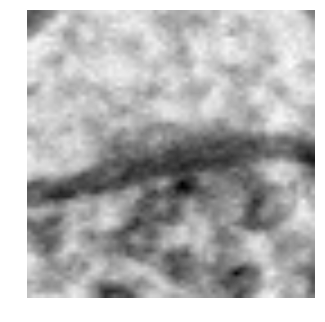

no synapse present - true negative


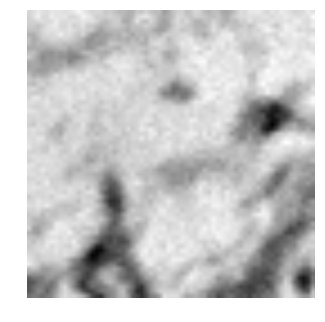

synapse present - false negative


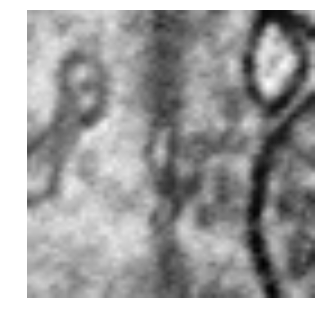

no synapse present - false positive


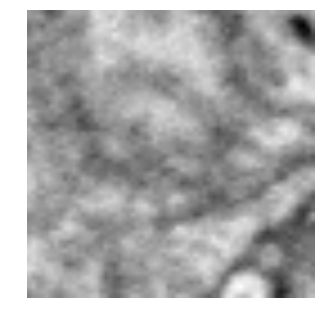

In [25]:
# here we can inspect results

valid_labels = np.asarray(prob_syn > thresh,dtype='int')
# find images we did well on
idx_correct_syn = np.where((valid_labels == yvalid) & (yvalid == 1))[0]
idx_correct_nosyn = np.where((valid_labels == yvalid) & (yvalid == 0))[0]
# find images we did poorly on

idx_wrong_syn = np.where((valid_labels != yvalid) & (yvalid == 1))[0]
idx_wrong_nosyn = np.where((valid_labels != yvalid) & (yvalid == 0))[0]
import ndparse as ndp

print('synapse present - true positive')
ndp.plot(imvalid[idx_correct_syn[3]])

print('no synapse present - true negative')
ndp.plot(imvalid[idx_correct_nosyn[3]])

print('synapse present - false negative')
ndp.plot(imvalid[idx_wrong_syn[3]])

print('no synapse present - false positive')
ndp.plot(imvalid[idx_wrong_nosyn[3]])

In [26]:
# Validate performance on test set (should only run/score once!)

data = np.load('./synchallenge2017_test_notruth.npz')

imtest = data['imtest']
annotest = data['annotest']

# Extract features from test set
xtest = extract_features(imtest)

# Run classifier on test set
scoretest = clf.predict_proba(xvalid)

# Post-processing
prob_syntest = scoretest[:,1]
syntest_predict = prob_syntest > thresh
syntest_predict = np.asarray(syntest_predict,dtype = 'uint8')

# save file and upload to google docs with label vector
np.save(your_name+'_synchallenge_testdata.npy',syntest_predict)